In [1]:
import cv2
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar

from thinning import zhangSuen
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [3]:
def getHist(img, axes=0):
    hist = []
    if axes == 0:
        for i in range(img.shape[1]):
            hist.append(np.sum(img[:, i]))
    else:
        for i in range(img.shape[0]):
            hist.append(np.sum(img[i, :]))
            
    return np.array(hist)

In [4]:
def showHist(hist):
    plt.figure()
    bar(np.arange(len(hist)), hist, width=0.8, align='center')

In [5]:
def thin(img):
    img = np.invert(img)
    
    Otsu_Threshold = threshold_otsu(img)
    thresholded = img < Otsu_Threshold    # must set object region as 1, background region as 0 !

    return zhangSuen(thresholded)

In [6]:
def toSkeleton(img):
    binary = img.copy()
    binary[binary <= 127] = 0
    binary[binary > 127] = 1
    return (skeletonize(binary) + 0)

In [7]:
def breakLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)

    ## (3) minAreaRect on the nozeros
    H,W = img.shape[:2]
    (cx,cy), (w,h), ang = ret
    
    if (H > W and w > h) or (H < W and w < h):
        w,h = h,w
        ang += 90

    # ## (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))
    
    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]
    
    uppers_mod = [uppers[0]]
    lowers_mod = [lowers[0]]
    
    for i in range(1, len(uppers)):
        if (lowers[i] - lowers[i-1]) > 10:
            uppers_mod.append(uppers[i])
            lowers_mod.append(lowers[i])

    lines = []
    if len(uppers_mod) == len(lowers_mod):
        for i in range(len(uppers_mod)):
            lines.append(rotated[uppers_mod[i]-5:lowers_mod[i]+5, :])

    return lines

In [8]:
def breakWords(line):
    H, W = line.shape
    hist = cv2.reduce(line, 0, cv2.REDUCE_AVG).reshape(-1)
    
    th = 2
    lefts = [x for x in range(W-1) if hist[x] <= th and hist[x+1] > th]
    rights = [x for x in range(W-1) if hist[x] > th and hist[x+1] <= th]

    words = []
    if len(lefts) == len(rights):
        for i in range(len(rights)):
            words.append(line[:, lefts[i]:rights[i]])

    return words

In [9]:
def extractTemplate(template, isSkeleton=True):
    if not isSkeleton:
        template = toSkeleton(template)
    template = template[~np.all(template == 0, axis=1)]
    mask = (template == 0).all(0)
    template = template[:, ~mask]
    
    return template

In [10]:
def templateMatch(word, template, threshold=0.4):
    if template.shape[0] > word.shape[0] or template.shape[1] > word.shape[1]:
        return 0

    original = word.copy()
    baseLine = getBaseLine(original)
    skeleton = toSkeleton(original)

    original = original.astype(np.uint8)
    template = template.astype(np.uint8)
    
#     bgr_img = cv2.cvtColor((255 * (original + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(original, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    for pt in zip(*loc[::-1]):
        return pt[0] + w
#         cv2.rectangle(bgr_img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
    
    return 0

In [11]:
def addCharSeparetor(word):
    binary = word.copy()
    binary[binary <= 127] = 0
    binary[binary > 127] = 1
    skeleton = skeletonize(binary) + 0
    hist = []
    for i in range(skeleton.shape[1]):
        hist.append(np.sum(skeleton[:, i]))

    diff = np.diff(hist)
    splitters = np.where(diff > 0)[0]
    if len(splitters) == 0:
        return []

    mod_splitters = [splitters[0]]
    for i in range(1, len(splitters)):
        if i != 1:
            if splitters[i] - splitters[i-1] >= 3:
                mod_splitters.append(splitters[i])
        else:
            if splitters[i] - splitters[i-1] >= 6:
                mod_splitters.append(splitters[i])

    bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for splitter in mod_splitters:
        cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
        
    return bgr_skeleton

In [12]:
def getBaseLine(word):
    skeleton = toSkeleton(word)
    
    hist = []
    for i in range(word.shape[0]):
        hist.append(np.sum(word[i, :]))

    baseLine = np.where(hist == np.max(hist))[0][0]
    return baseLine

In [13]:
def addEmptySpaceSep(skeleton):
    hist = []
    for i in range(skeleton.shape[1]):
        hist.append(np.sum(skeleton[:, i]))
        
    splitters = []
    notEmpty = False
    for i in range(len(hist)):
        if notEmpty and hist[i] == 0:
            splitters.append(i)
            notEmpty = False

        if hist[i] != 0:
            notEmpty = True
            
    return splitters

In [14]:
def isFakeAlef(word, splitter):
    start = 0
    for i in range(word.shape[1]):
        if np.sum(word[:, i]) > 0:
            start = i
            break
    subWord = word[:, start:splitter]
    
    if subWord.shape[1] > 3:
        return False
    for i in range(subWord.shape[1]):
        column = subWord[:, i]
        indecies = np.where(column > 0)[0]
        
        if len(indecies) > 1 and (abs(indecies[-1] - indecies[0]) > 3):
            return False
        
    return True

In [15]:
sen = (cv2.imread("./templates/sen_template.png", 0) / 255).astype(np.uint8)
yStart = (cv2.imread("./templates/y_template.png", 0) / 255).astype(np.uint8)
senStart = (cv2.imread("./templates/sen_start_template.png", 0) / 255).astype(np.uint8)
senMiddle = (cv2.imread("./templates/sen_middle_template.png", 0) / 255).astype(np.uint8)
hStart = (cv2.imread("./templates/7_template.png", 0) / 255).astype(np.uint8)
shenMiddle = (cv2.imread("./templates/shen_middle_template.png", 0) / 255).astype(np.uint8)

In [23]:
def new_method(word):
    baseLine = getBaseLine(word)
    bgr_skeleton = cv2.cvtColor((255 * (toSkeleton(word) + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    splitters = []
    firstSenSep = templateMatch(word, senStart, threshold=0.6)
    if firstSenSep != 0:
        splitters.append(firstSenSep)
        word = word[:, firstSenSep:]
    else:
        firstSenSep = templateMatch(word, yStart, threshold=0.55)
        if firstSenSep != 0:
            splitters.append(firstSenSep)
            word = word[:, firstSenSep:]
        

    skeleton = toSkeleton(word)
    upperHalf = skeleton[0:baseLine-1, :]
    if np.sum(upperHalf) < 5:
        upperHalf = np.flip(skeleton[baseLine:, :], 0)
    
    fullHist = []
    for i in range(skeleton.shape[1]):
        fullHist.append(np.sum(skeleton[:, i]))

    hist = []
    for i in range(upperHalf.shape[1]):
        hist.append(np.sum(upperHalf[:, i]))
    diff = np.diff(hist)

    emptySpaceSplitters = addEmptySpaceSep(skeleton)
    for splitter in emptySpaceSplitters:
        splitters.append(splitter + firstSenSep)
        
    for i in range(1, len(diff)):
        if diff[i-1] != 0 and diff[i] == 0 and hist[i] == 0:
            splitters.append(i + firstSenSep)

    if len(splitters) == 0:
        return skeleton
    
    splitters.sort()
    start = 1
    modSplitters = []
    if len(splitters) > 1 and splitters[1] - splitters[0] <= 3 and splitters[1] in emptySpaceSplitters:
        modSplitters.append(splitters[1])
        start = 2
    else:
        modSplitters.append(splitters[0])
    for i in range(start, len(splitters)):
        if splitters[i] - splitters[i-1] > 3:
            modSplitters.append(splitters[i])
    
    nonCharacterFiltered = []
    if len(modSplitters) > 0:
        for i in range(len(modSplitters)-1):
            sub_hist = fullHist[modSplitters[i]-firstSenSep:modSplitters[i+1]-firstSenSep]
            empty = True
            for value in sub_hist:
                if value > 1:
                    empty = False
                    break

            if not empty:
                nonCharacterFiltered.append(modSplitters[i])

    if np.sum(hist[modSplitters[-1]-firstSenSep:]) > 0:
        nonCharacterFiltered.append(modSplitters[-1])

    if len(nonCharacterFiltered) == 0:
        return skeleton

    extraSplitterFiltered = []
    if not isFakeAlef(skeleton, nonCharacterFiltered[0]):
        extraSplitterFiltered.append(nonCharacterFiltered[0])
        
    for i in range(1, len(nonCharacterFiltered)):
        extraSplitterFiltered.append(nonCharacterFiltered[i])
    
    for splitter in extraSplitterFiltered:
        cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
    
    return bgr_skeleton

In [26]:
img = cv2.imread("./DataSets/test2.png")
lines = breakLines(img)

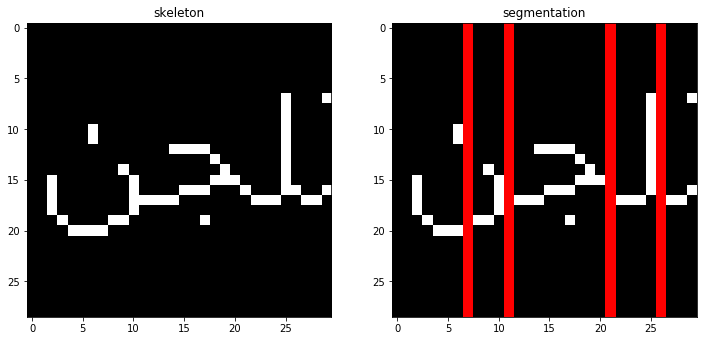

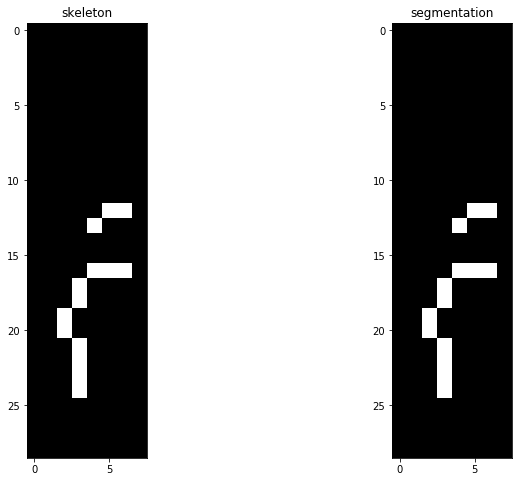

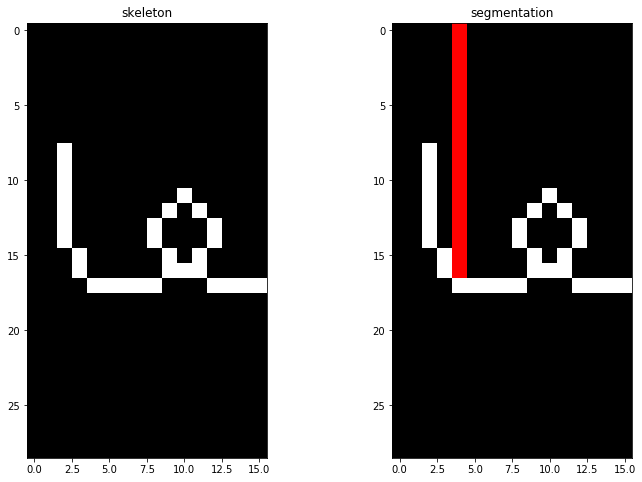

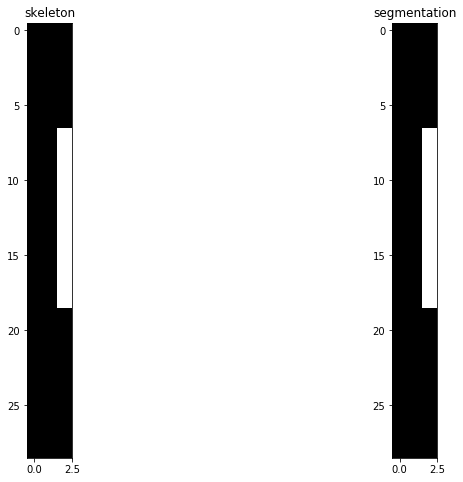

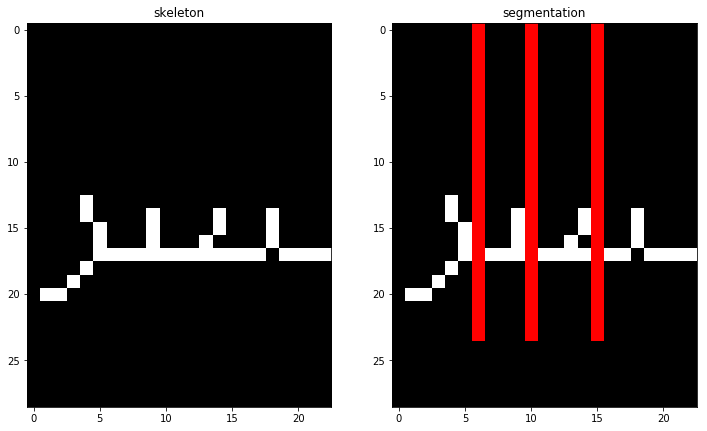

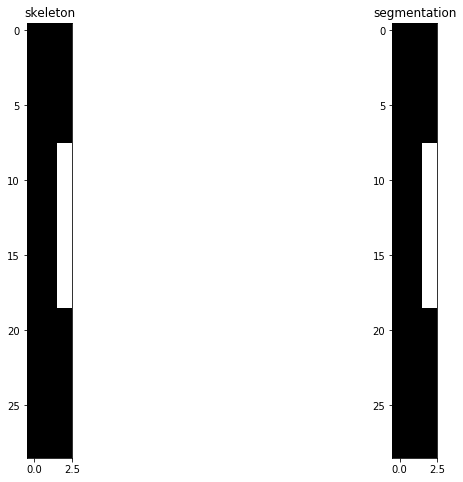

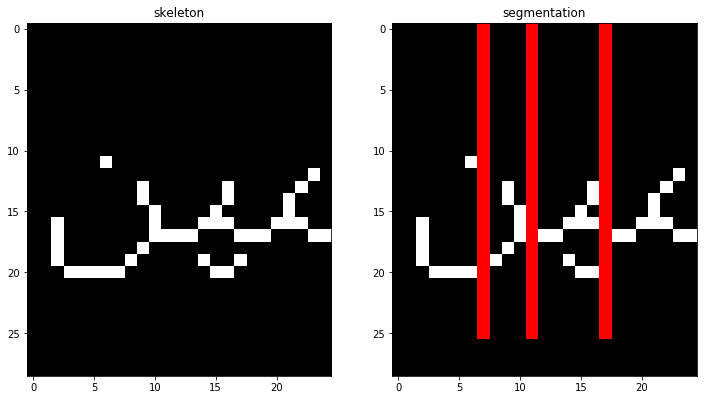

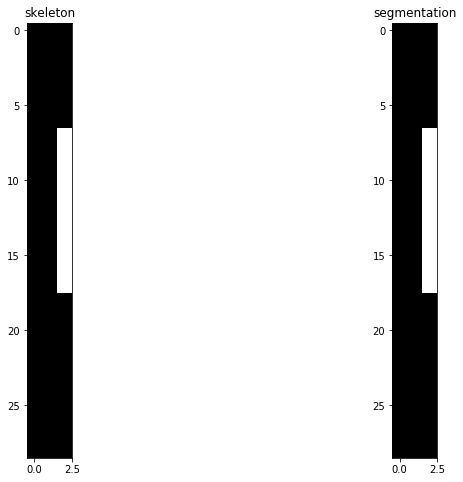

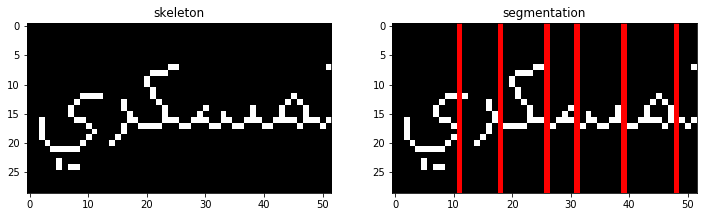

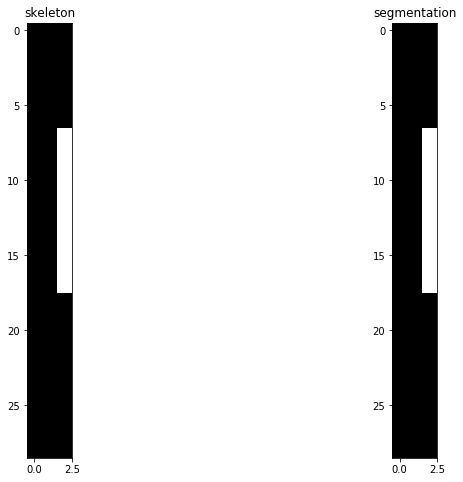

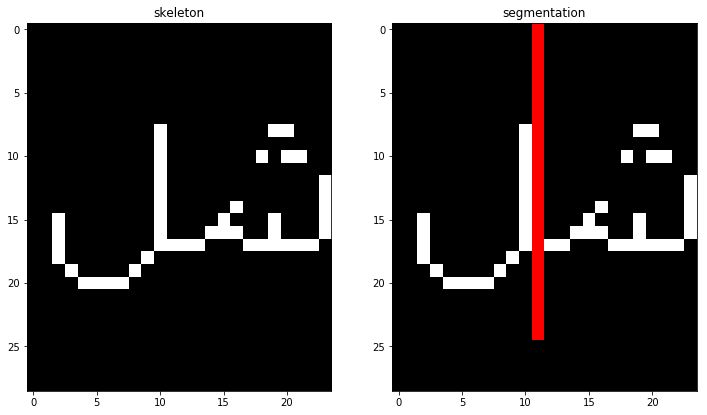

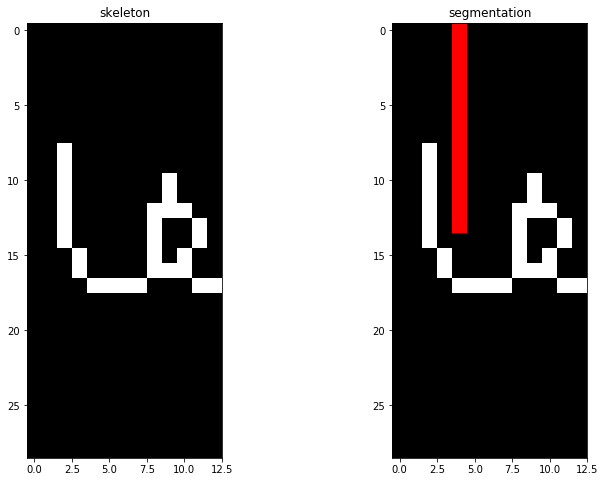

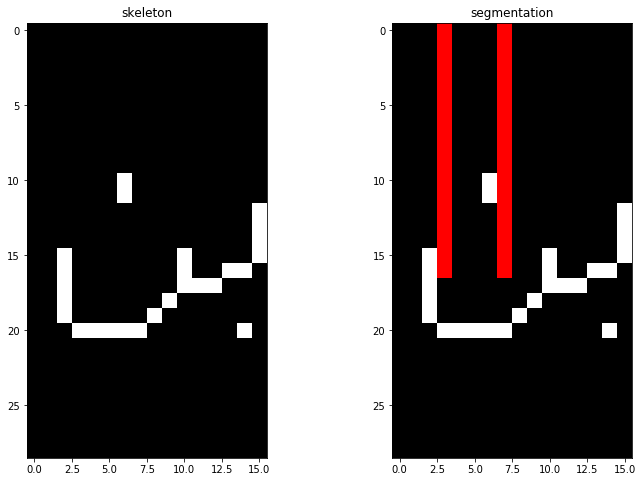

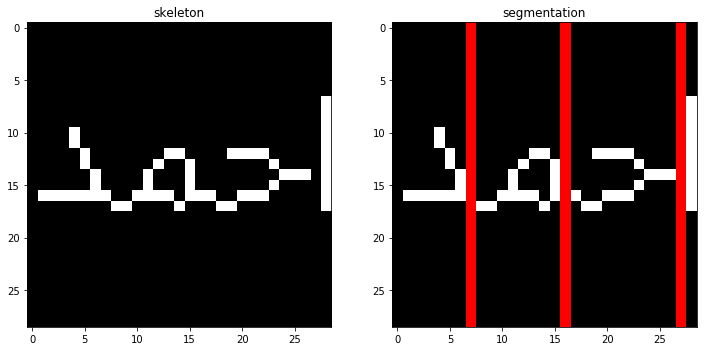

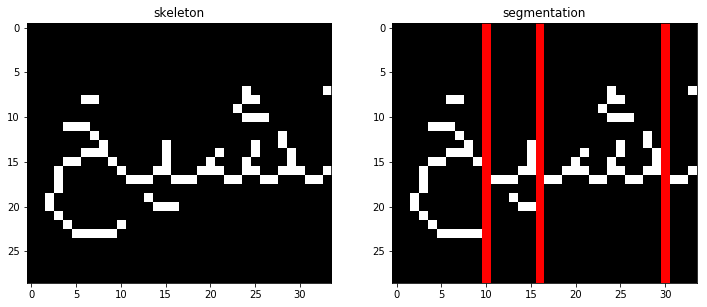

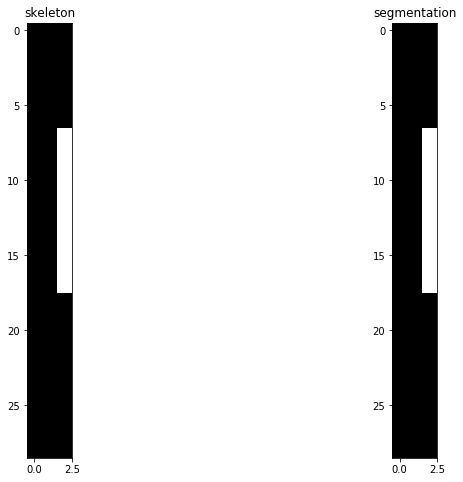

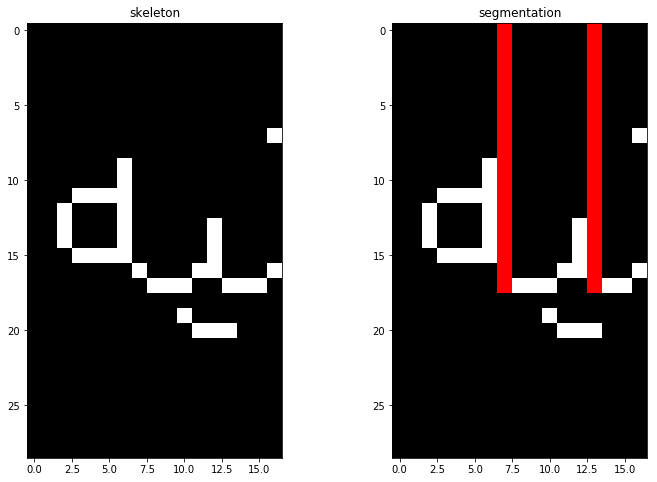

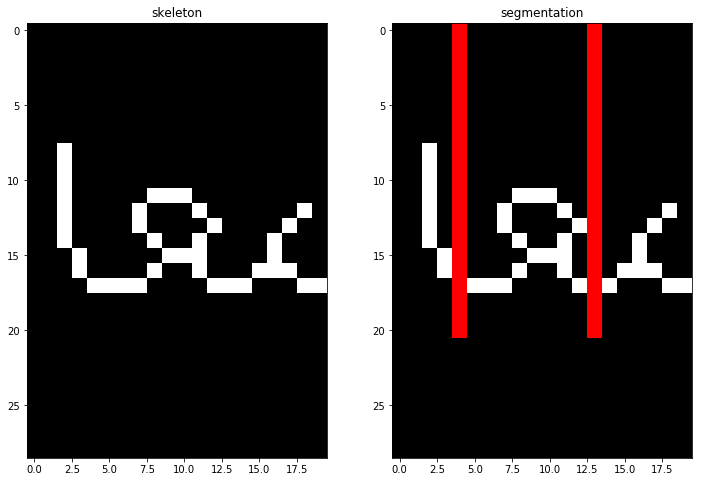

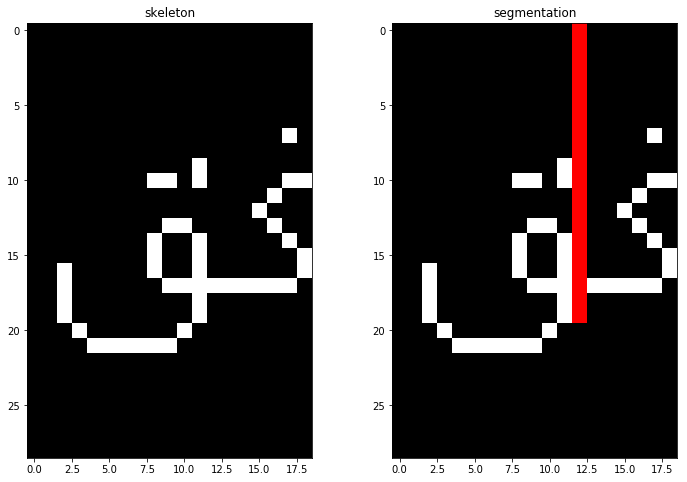

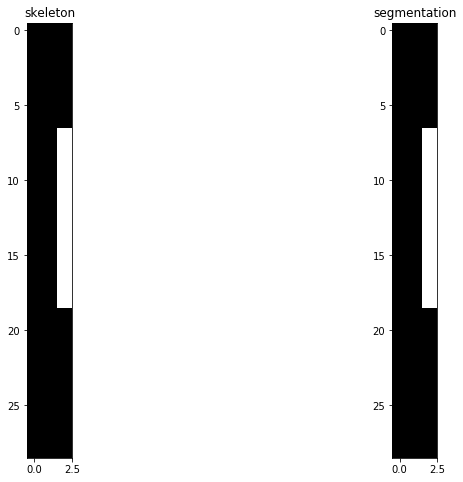

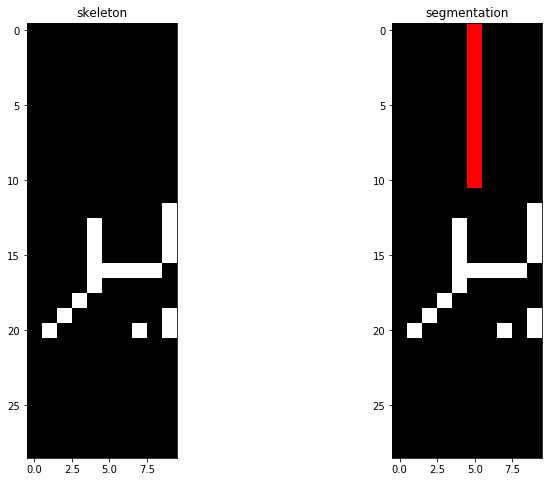

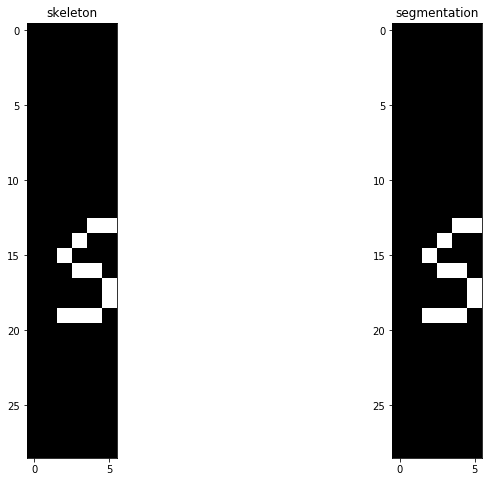

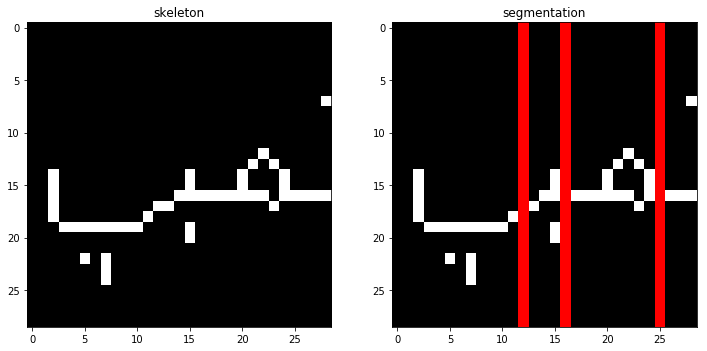

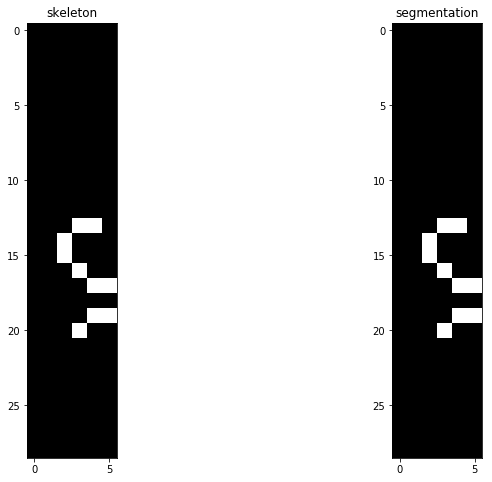

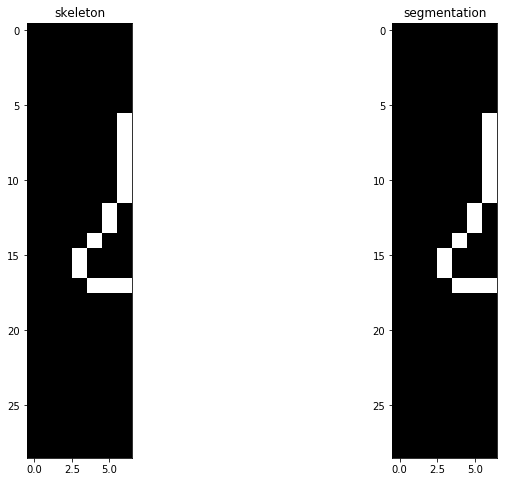

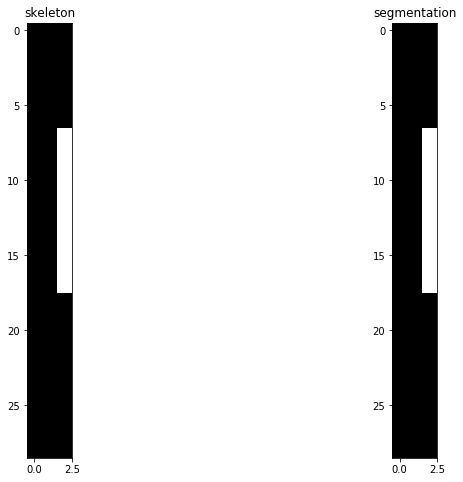

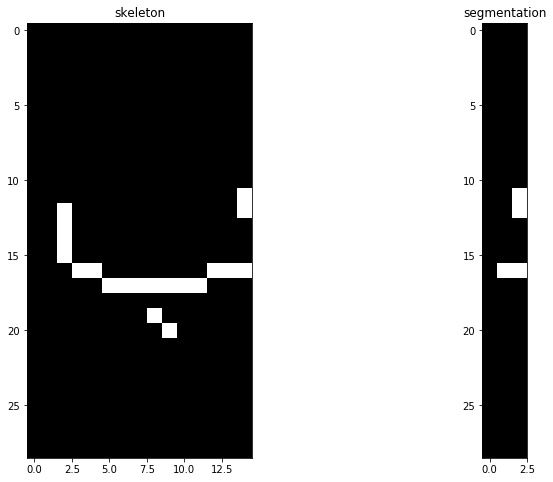

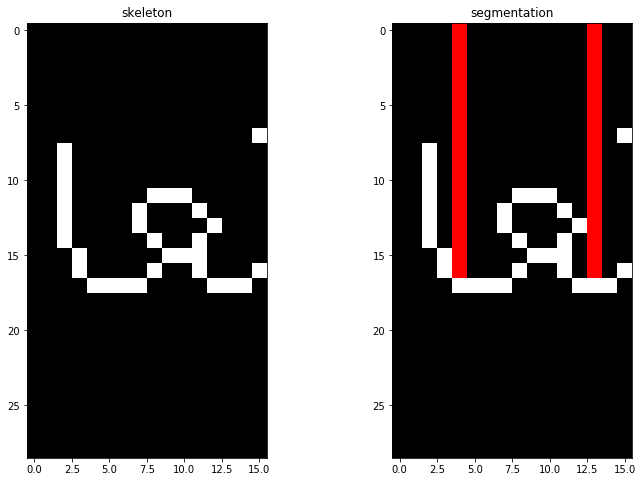

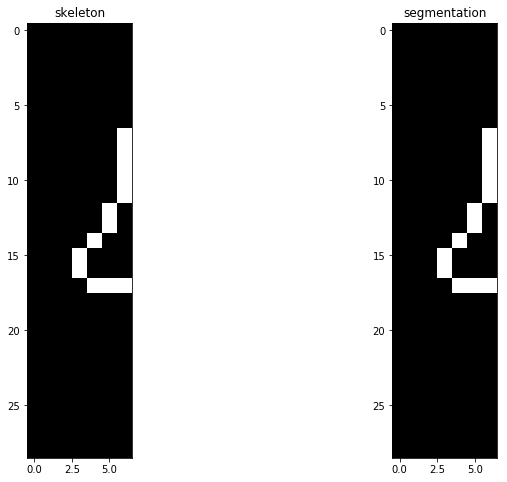

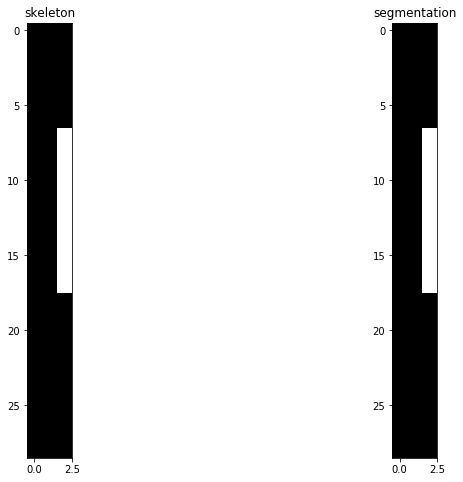

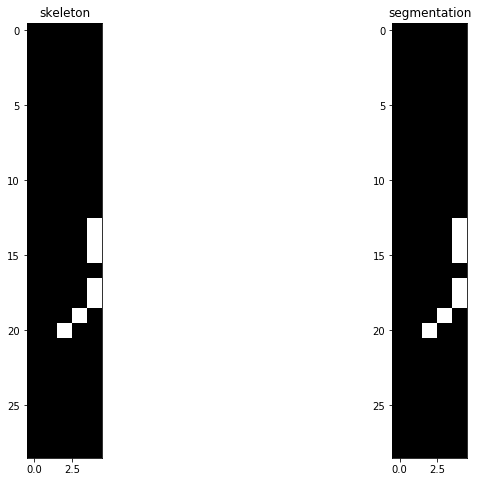

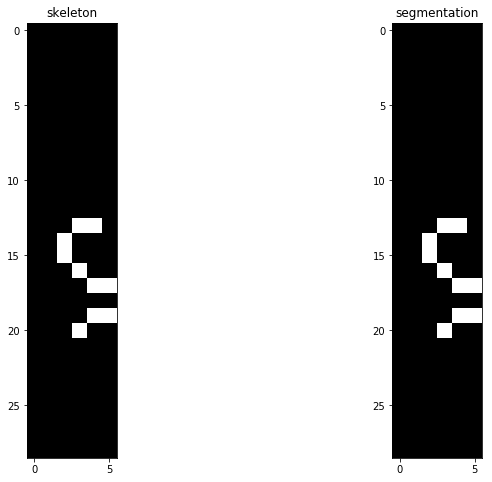

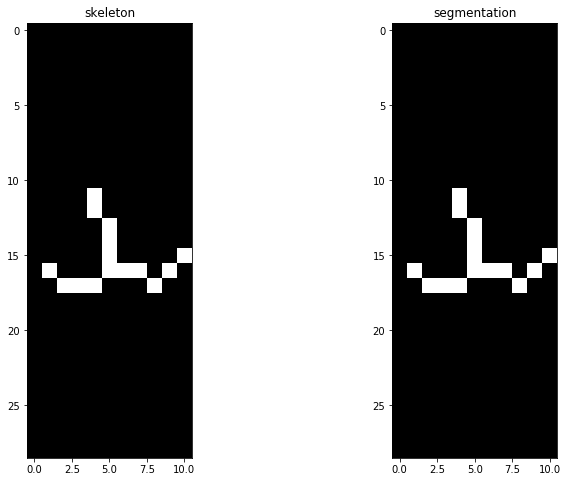

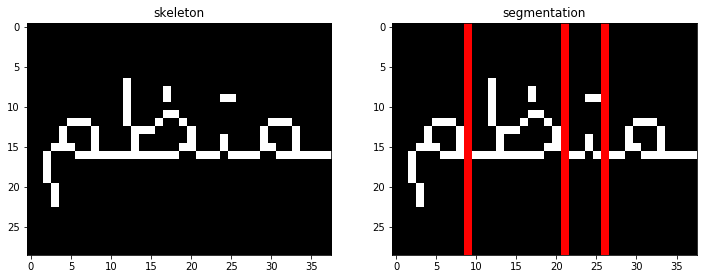

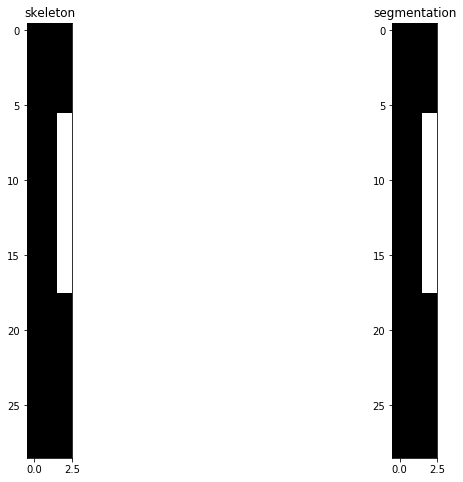

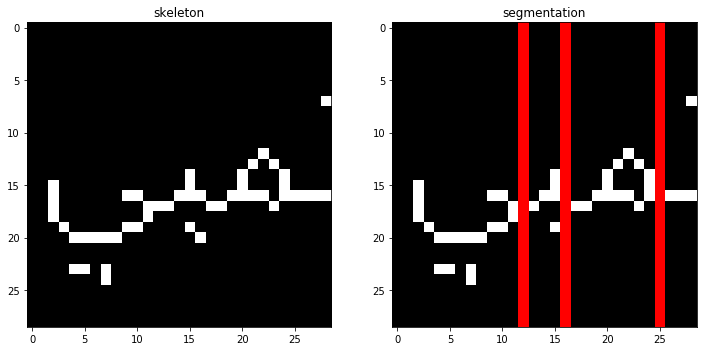

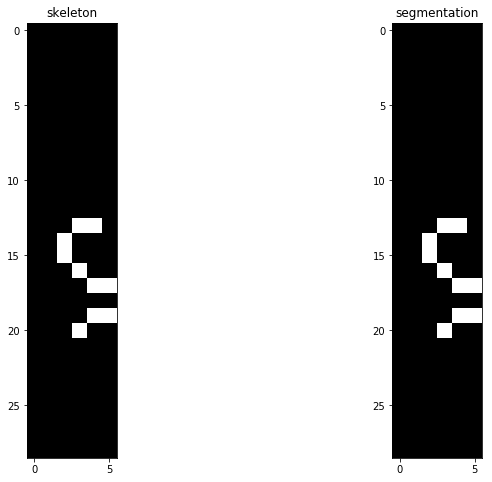

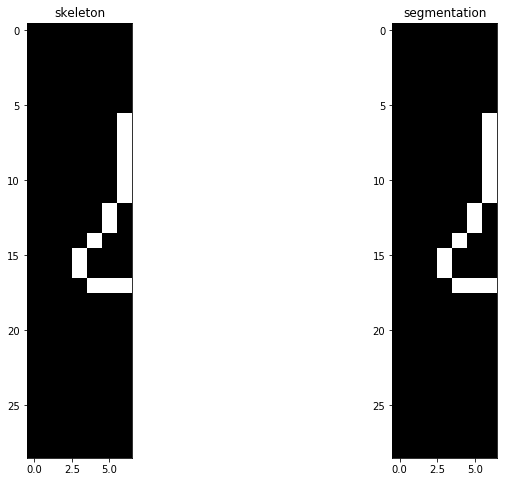

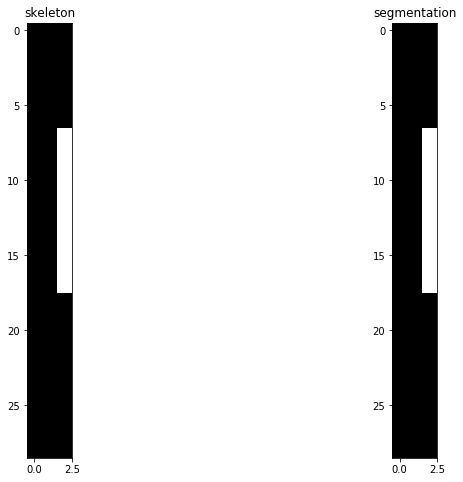

In [27]:
words = breakWords(lines[5])
for word in words:
    show_images([toSkeleton(word), new_method(word.copy())], ["skeleton", "segmentation"])

[(5, 4.0), (9, 4.0)]


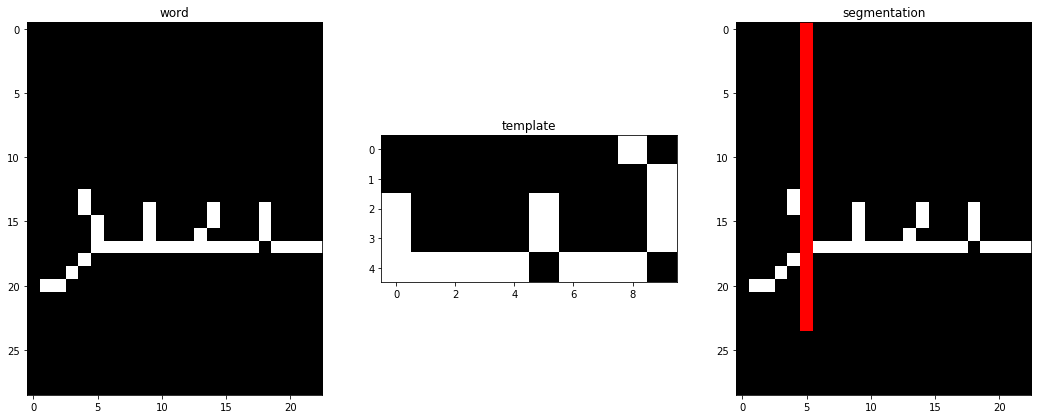

In [48]:
senHist = getHist(sen)
shenMiddleHist = getHist(shenMiddle)
shenMiddleHist[-1] = 1
shenMiddleHist = np.append(shenMiddleHist, 4).astype(np.uint8)


skeleton = toSkeleton(words[4])
wordHist = getHist(skeleton)

maybe = []
for i in range(len(wordHist)-9):
    distance = np.sum(abs(wordHist[i:i+10] - senHist))
    if distance < 5:
        maybe.append((i, distance))

print(maybe)
minDistance = 5
splitter = None
for window in maybe:
    if window[1] < minDistance:
        minDistance = window[1]
        splitter = window[0]

if splitter != None:
    bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
#     cv2.line(bgr_skeleton, (splitter+9, 0), (splitter+9, bgr_skeleton.shape[1]), (255, 0, 0), 1)

    show_images([skeleton, sen, bgr_skeleton], ["word", "template", "segmentation"])

In [47]:
senHist = getHist(sen)
skeleton = toSkeleton(words[8])
wordHist = getHist(skeleton)
# print(sen.shape)

maybe = []
for i in range(len(wordHist)-9):
    temp = np.zeros((5, 10))
    letter = extractTemplate(skeleton[:, i:i+10])
    distance = np.sum(letter * sen)
    if distance < 5:
        maybe.append((i, distance))

print(maybe)
minDistance = 5
splitter = None
for window in maybe:
    if window[1] < minDistance:
        minDistance = window[1]
        splitter = window[0]

print(splitter)
if splitter != None:
    bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
#     cv2.line(bgr_skeleton, (splitter+9, 0), (splitter+9, bgr_skeleton.shape[1]), (255, 0, 0), 1)

    show_images([skeleton, sen, bgr_skeleton], ["word", "template", "segmentation"])

ValueError: cannot reshape array of size 96 into shape (5,10)

In [ ]:
# skeleton = toSkeleton(words[6])
# template = extractTemplate(skeleton[:, :11])
# show_images([skeleton, template])
# print(template.shape)
# cv2.imwrite("y_template.png", template*255)

34


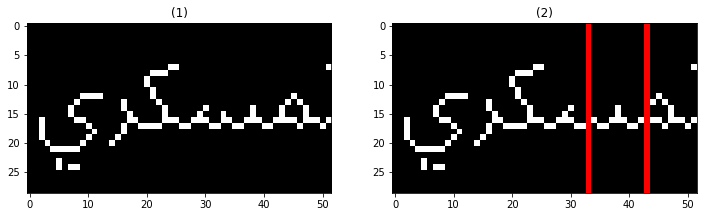

In [31]:
splitter = templateMatch(words[8], sen, threshold=0.5)
print(splitter)
bgr_skeleton = cv2.cvtColor((255 * (toSkeleton(words[8]) + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.line(bgr_skeleton, (splitter-1, 0), (splitter-1, bgr_skeleton.shape[1]), (255, 0, 0), 1)
cv2.line(bgr_skeleton, (splitter+9, 0), (splitter+9, bgr_skeleton.shape[1]), (255, 0, 0), 1)

show_images([toSkeleton(words[8]), bgr_skeleton])